# LSTM: Sequence-aware “FoxSpeedScore” Generator v1

Train your LSTM to analyze a horse’s past performance sequence and predict a FoxSpeedScore that reflects its projected strength today.

✅ You can then: • Rank horses by this score for simple win/place bets • Or use it as a ranking feature in your CatBoost/YetiRank model

⸻

🔍 How Accurate is Ranking by Speed Score Alone?

🔥 The Good:

If your LSTM is trained on well-normalized, consistent historical speed signals: • Relative ordering can be quite meaningful • Especially in smaller fields or when you’re identifying top 3–4 finishers • Even if absolute values are off, ranking is often more robust

❄️ The Limitations: • LSTM alone won’t account for today’s track conditions, surface bias, jockey/trainer changes, distance, class jump/drop • It may favor horses that ran fast recently but are now outclassed or mispositioned

In [56]:
spark.stop()

In [1]:
# Setup Environment
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ.pop("CUDA_VISIBLE_DEVICES", None)
from pyspark.sql import Window
# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
import torch.nn as nn
import numpy as np
import optuna.visualization as viz
import pyspark.sql.functions as F
#from pyspark.sql.window import Window
from pyspark.sql.functions import (to_date, date_format, lpad, concat_ws, collect_list, struct, 
                                   col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [3]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [4]:
def setup_logging():
    """Sets up logging to file (FoxSpeedScore.log)."""
    log_dir = '/home/exx/myCode/horse-racing/FoxRiverAIRacing/logs'
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, 'LSTM_GPS_Train.log')

    # Truncate old logs
    with open(log_file, 'w'):
        pass

    logger = logging.getLogger()
    if logger.hasHandlers():
        logger.handlers.clear()
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.INFO)

    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info("Logging has been set up successfully.")

In [5]:
# def gps_sql_queries():
#     queries = {
#         "gps_horse": """
#             SELECT g.course_cd, g.race_date,g.race_number,
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
#             time_stamp, speed, progress, stride_frequency,
#             re.axciskey, h.horse_id, re.official_fin, h.horse_name
#             FROM gpspoint g
#             JOIN results_entries re on g.course_cd = re.course_cd
#                 AND g.race_date = re.race_date
#                 AND g.race_number = re.race_number
#                 AND g.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey
#             WHERE speed is not null
#             AND progress is not null
#             AND stride_frequency is not null
#             """
#          "sectionals": """
#             SELECT s.course_cd, s.race_date, s.race_number, 
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
#             s.gate_name, s.gate_numeric, s.length_to_finish, s.sectional_time, s.running_time, 
#             s.distance_back, s.distance_ran, s.number_of_strides, s.post_time, re.official_fin
#             FROM sectionals s
#             JOIN results_entries re on s.course_cd = re.course_cd
#                 AND s.race_date = re.race_date
#                 AND s.race_number = re.race_number
#                 AND s.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey 
#             WHERE length_to_finish is not null
#             AND sectional_time is not null
#             AND running_time is not null
#             AND distance_back is not null
#             AND distance_ran is not null
#             AND distance_ran is not null
#            """
#     }
#     return queries

In [6]:
# queries = gps_sql_queries()
# dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
#         # Suppose we have a dictionary of queries
# for name, df in dfs.items():
#     logging.info(f"DataFrame '{name}' loaded. Schema:")
#     df.printSchema()
#     if name == "gps_horse":
#         gps_horse_df = df
#     elif name == "sectionals":
#         sectionals_df = df    
#     else:
#         logging.error(f"Unknown DataFrame name: {name}")
#         continue


In [7]:

# start_time = time.time()
# gps_horse_df.write.mode("overwrite").parquet(f"{parquet_dir}/gps_horse_df")
# # sectionals_df.write.mode("overwrite").parquet(f"{parquet_dir}/sectionals_df")
# logging.info(f"Data written to Parquet in {time.time() - start_time:.2f} seconds")
    

In [8]:
gps_horse_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/gps_horse_df")
#sectionals_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/sectionals_df")


In [9]:
gps_horse_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- time_stamp: timestamp (nullable = true)
 |-- speed: double (nullable = true)
 |-- progress: double (nullable = true)
 |-- stride_frequency: double (nullable = true)
 |-- axciskey: string (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- horse_name: string (nullable = true)



In [10]:
#gps_horse_df.show(5)

In [11]:
# Construct a unique race_id using course_cd, race_date, and race_number
gps_horse_df = gps_horse_df.withColumn(
    "race_id",
    concat_ws(
        "_",
        col("course_cd"),
        date_format(col("race_date"), "yyyyMMdd"),
        lpad(col("race_number").cast("string"), 2, "0")
    )
)

# Convert race_date to a proper date format
gps_horse_df = gps_horse_df.withColumn("race_date", to_date(col("race_date")))


## Sort

In [12]:
# Partition by (horse_id, race_id) so that each horse's race is grouped
# Then order by time_stamp for chronological order *within* the race.
window_spec = Window.partitionBy("horse_id", "race_id").orderBy(F.col("time_stamp").asc())

gps_horse_df = gps_horse_df.withColumn("ts_ordinal", F.row_number().over(window_spec))

## Remove Progress with 0's after the first occurrence

In [13]:
from pyspark.sql import Window, functions as F

# Partition by (horse_id, race_id)
partition_window = Window.partitionBy("horse_id", "race_id")

# Define a column "first_zero" = the minimum ts_ordinal among rows where progress=0
gps_horse_df = gps_horse_df.withColumn(
    "first_zero",
    F.min(F.when(F.col("progress") == 0, F.col("ts_ordinal"))).over(partition_window)
)

# Now filter:
# Keep all rows if progress != 0
# OR if ts_ordinal equals that first_zero (i.e., the first time we see progress=0).
gps_horse_df = gps_horse_df.filter(
    (F.col("progress") != 0) |
    (F.col("ts_ordinal") == F.col("first_zero"))
)

## Assign Target/Relevance:

In [14]:
from pyspark.sql import functions as F

def assign_piecewise_log_labels_spark(df, alpha=30.0, beta=4.0):
    df_out = df.withColumn(
        "relevance",
        F.when(F.col("official_fin") == 1, 70.0)
         .when(F.col("official_fin") == 2, 56.0)
         .when(F.col("official_fin") == 3, 44.0)
         .when(F.col("official_fin") == 4, 34.0)
         .otherwise(F.lit(alpha) / F.log(F.lit(beta) + F.col("official_fin")))
    ).withColumn(
        "top4_label",
        F.when(F.col("official_fin") <= 4, F.lit(1)).otherwise(F.lit(0))
    )
    return df_out

In [15]:
gps_horse_df = assign_piecewise_log_labels_spark(gps_horse_df)

### Compute Sequence Lenghts

### Drop Rows with <60 and >140 Sequences

In [18]:
# Note, only run the first command if you want to see the actual range before filtering
# Step 1: Compute sequence lengths per horse per race
df_seq_len = gps_horse_df.groupBy("race_id", "horse_id").agg(F.count("*").alias("seq_length"))

# Step 2: Filter sequences with length between 60 and 140
filtered_df = df_seq_len.filter((F.col("seq_length") >= 60) & (F.col("seq_length") <= 140))

# Step 3: Join the filtered sequence lengths back with the original data
gps_horse_df = gps_horse_df.join(filtered_df, on=["race_id", "horse_id"], how="inner")

### NOTE: 
If the range in the histogram shows sequences between 60 and 140, then the step below to filter rows with sequence <60 and >140 has already been performed. 

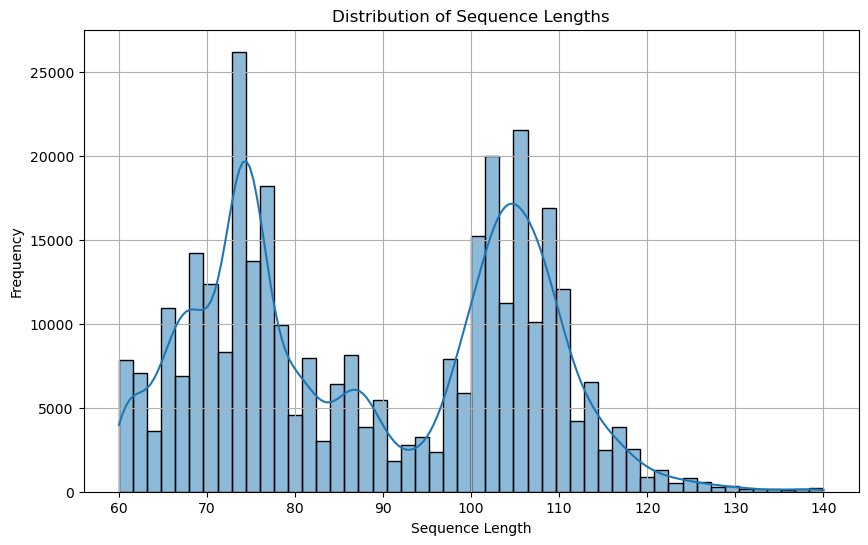

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_seq_len is a DataFrame with a 'seq_length' column
# If df_seq_len is a PySpark DataFrame, convert it to Pandas
df_seq_len_pd = df_seq_len.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_seq_len_pd['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Padding Sequences to a Fixed Length

###  Step 1: Convert to Sequence Format

In [57]:
from pyspark.sql.functions import collect_list, sort_array, struct, count
from pyspark.sql.window import Window

def make_sequences_window(df, features):
    # build the 'feature_struct'
    df = df.select(
        "race_id", "horse_id",
        "ts_ordinal",
        struct(*[F.col(f) for f in features]).alias("feature_struct")
    )

    w = (
        Window.partitionBy("race_id", "horse_id")
              .orderBy(F.asc("ts_ordinal"))
              .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    )

    df = df.withColumn(
        "sequence",
        collect_list("feature_struct").over(w)
    ).withColumn(
        "rn",
        row_number().over(
            Window.partitionBy("race_id", "horse_id").orderBy(F.asc("ts_ordinal"))
        )
    )

    count_window = Window.partitionBy("race_id", "horse_id")
    df = df.withColumn(
        "count_in_part",
        count("*").over(count_window)
    )

    # Now keep only the row where 'rn == count_in_part'
    df = df.filter(F.col("rn") == F.col("count_in_part"))

    df = df.select("race_id", "horse_id", "sequence")

In [22]:
features = ["speed", "progress", "stride_frequency"]
all_seq = make_sequences(gps_horse_df, features)

In [23]:
all_seq.columns

['race_id', 'horse_id', 'sequence']

In [24]:
# Join race_date and relevance back into our sequences.
# We rename the joined relevance column to avoid duplicates.
all_seq = all_seq.join(
    gps_horse_df.select("race_id", "horse_id", "race_date", F.col("relevance").alias("joined_relevance"))
        .dropDuplicates(["race_id", "horse_id"]),
    on=["race_id", "horse_id"],
    how="left"
)
# Remove any pre-existing relevance column and rename the joined one.
all_seq = all_seq.drop("relevance").withColumnRenamed("joined_relevance", "relevance")

In [25]:
all_seq.columns

['race_id', 'horse_id', 'sequence', 'race_date', 'relevance']

### Convert to Pandas

In [26]:
all_pd = all_seq.toPandas()

# Sort by race_date to maintain temporal order
all_pd = all_pd.sort_values("race_date").reset_index(drop=True)

###  ✅ TimeSeriesSplit with Rolling-Window Cross-Validation

In [27]:
# --- Step 1: Prepare Your Data ---
# Assume full_pd is your Pandas DataFrame with the following columns:
#   - "race_date": the date of the race (used for sorting)
#   - "padded_seq": the padded sequence (a list of dicts or arrays, one per sample)
#   - "relevance": the target variable

# First, sort the DataFrame by race_date to ensure temporal order.
full_pd_sorted = all_pd.sort_values("race_date").reset_index(drop=True)

Dataset time range: 2022-01-01 to 2025-03-23
Fold 1: Train indices 0-55891, Test indices 55892-111780
Fold 2: Train indices 0-111780, Test indices 111781-167669
Fold 3: Train indices 0-167669, Test indices 167670-223558
Fold 4: Train indices 0-223558, Test indices 223559-279447
Fold 5: Train indices 0-279447, Test indices 279448-335336


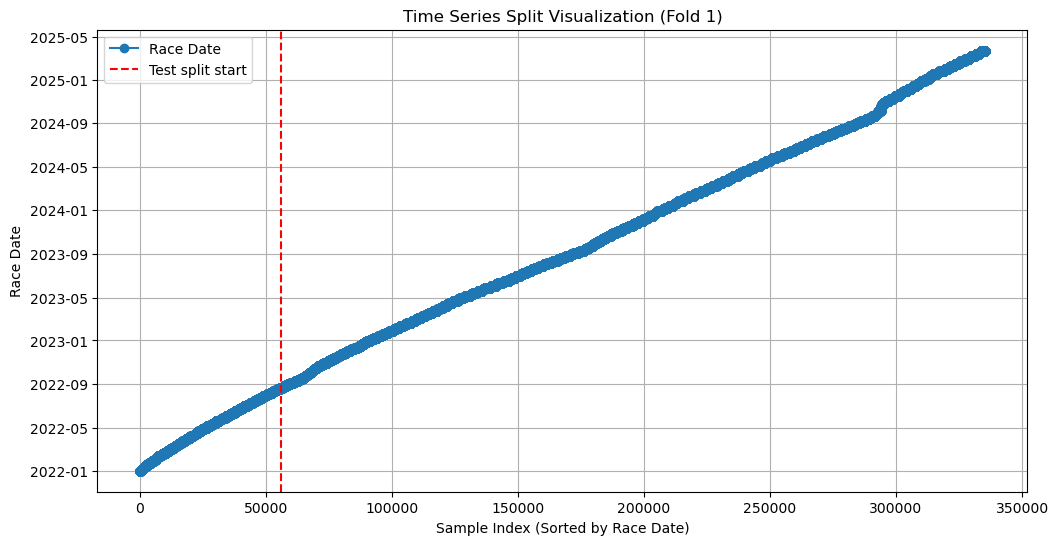

In [28]:
# --- Assume 'all_pd' is your sorted Pandas DataFrame (sorted by race_date) ---
print("Dataset time range:", all_pd["race_date"].min(), "to", all_pd["race_date"].max())

# Create a TimeSeriesSplit object with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Collect indices for each split
splits = list(tscv.split(all_pd))
for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {fold+1}: Train indices {train_idx[0]}-{train_idx[-1]}, Test indices {test_idx[0]}-{test_idx[-1]}")

# --- Plotting one of the splits for visualization ---
# Let's visualize the first split:
train_idx, test_idx = splits[0]

plt.figure(figsize=(12, 6))
# Plot the race_date for each sample as points
plt.plot(all_pd.index, pd.to_datetime(all_pd["race_date"]), marker='o', linestyle='-', label='Race Date')

# Mark the split boundary: first index of the test set
plt.axvline(x=test_idx[0], color='red', linestyle='--', label='Test split start')

plt.xlabel("Sample Index (Sorted by Race Date)")
plt.ylabel("Race Date")
plt.title("Time Series Split Visualization (Fold 1)")
plt.legend()
plt.grid(True)
plt.show()

### Pad Sequences: 

Convert the sequences to a fixed length (e.g., 140) and prepare them for modeling.

In [29]:

def pad_sequence(seq, target_len):
    pad_val = {"speed": 0.0, "progress": 0.0, "stride_frequency": 0.0}
    seq = seq[:target_len]
    return seq + [pad_val] * (target_len - len(seq))

def prepare_unified_lstm_dataset(df, target_len=140):
    df = df.drop_duplicates(subset=["race_id", "horse_id"])
    df = df[df["relevance"].notna()]
    df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x, target_len))

    X_all = np.array([
        [[d["speed"], d["progress"], d["stride_frequency"]] for d in seq]
        for seq in df["padded_seq"]
    ], dtype=np.float32)

    y_all = df["relevance"].values.astype(np.float32)
    return X_all, y_all, df

In [30]:
X_all, y_all, full_pd = prepare_unified_lstm_dataset(all_pd, target_len=140)

# Split & Normalize

## Define Helper Functions

In [31]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

# --------------------------------------------
# Outlier Capping (Train/Val versions)
# --------------------------------------------
def cap_outliers_X_train_only(X_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from X_train, apply to X_train.
    Returns: (X_train_capped, (lower_bounds, upper_bounds))
    """
    num_samples, seq_len, num_features = X_train.shape
    X_flat = X_train.reshape(-1, num_features)
    
    lower_bounds = np.percentile(X_flat, lower_percentile, axis=0)
    upper_bounds = np.percentile(X_flat, upper_percentile, axis=0)

    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    X_train_capped = X_flat_capped.reshape(num_samples, seq_len, num_features)
    return X_train_capped, (lower_bounds, upper_bounds)

def cap_outliers_X_val(X_val, bounds):
    """
    Apply the train-derived bounds to X_val, no new fit.
    """
    (lower_bounds, upper_bounds) = bounds
    num_samples, seq_len, num_features = X_val.shape
    X_flat = X_val.reshape(-1, num_features)
    
    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    return X_flat_capped.reshape(num_samples, seq_len, num_features)

def cap_outliers_y_train_only(y_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from y_train, apply to y_train.
    Returns: (y_train_capped, (lower_bound, upper_bound))
    """
    lower_bound = np.percentile(y_train, lower_percentile)
    upper_bound = np.percentile(y_train, upper_percentile)
    y_train_capped = np.clip(y_train, lower_bound, upper_bound)
    return y_train_capped, (lower_bound, upper_bound)

def cap_outliers_y_val(y_val, y_bounds):
    (lower_bound, upper_bound) = y_bounds
    return np.clip(y_val, lower_bound, upper_bound)

# --------------------------------------------
# PyTorch Dataset
# --------------------------------------------
class HorseRaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Build a "Train/Val" Prep Function

In [32]:
def build_lstm_dataloaders_time_series(
    X_all, 
    y_all, 
    batch_size=64, 
    n_splits=5,
    save_scalers=True,
    scaler_X_path="training_scalers_gpsscaler_X.pkl",
    scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_y.pkl"
):
    """
    1) Do TimeSeriesSplit on (X_all, y_all).
    2) Use last split as train/val.
    3) Cap outliers + scale on train only, apply same transforms to val.
    4) Build DataLoaders for train/val.
    5) Optionally save the scalers.
    """

    # ---------- (A) TimeSeriesSplit ----------
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = list(tscv.split(X_all))
    train_idx, val_idx = splits[-1]  # last split for validation

    X_train_raw, X_val_raw = X_all[train_idx], X_all[val_idx]
    y_train_raw, y_val_raw = y_all[train_idx], y_all[val_idx]

    # ---------- (B) Outlier capping ----------
    # Fit bounds on train, apply to val
    X_train_capped, X_bounds = cap_outliers_X_train_only(X_train_raw)
    X_val_capped = cap_outliers_X_val(X_val_raw, X_bounds)

    y_train_capped, y_bounds = cap_outliers_y_train_only(y_train_raw)
    y_val_capped = cap_outliers_y_val(y_val_raw, y_bounds)

    # ---------- (C) Scaling (train only) ----------
    # Flatten train
    num_train, seq_len, num_features = X_train_capped.shape
    X_train_flat = X_train_capped.reshape(-1, num_features)

    scaler_X = StandardScaler()
    X_train_flat_scaled = scaler_X.fit_transform(X_train_flat)
    X_train_scaled = X_train_flat_scaled.reshape(num_train, seq_len, num_features)

    # Flatten val, transform
    num_val = X_val_capped.shape[0]
    X_val_flat = X_val_capped.reshape(-1, num_features)
    X_val_flat_scaled = scaler_X.transform(X_val_flat)
    X_val_scaled = X_val_flat_scaled.reshape(num_val, seq_len, num_features)

    # Scale y (MinMaxScaler as example)
    scaler_y = MinMaxScaler()
    y_train_2d = y_train_capped.reshape(-1, 1)
    y_train_scaled = scaler_y.fit_transform(y_train_2d).flatten()

    y_val_2d = y_val_capped.reshape(-1, 1)
    y_val_scaled = scaler_y.transform(y_val_2d).flatten()

    # Optional: save scalers to disk for inference
    if save_scalers:
        joblib.dump(scaler_X, scaler_X_path)
        joblib.dump(scaler_y, scaler_y_path)
        print(f"Saved {scaler_X_path} and {scaler_y_path}")

    # ---------- (D) Build PyTorch Datasets & Loaders ----------
    train_dataset = HorseRaceDataset(X_train_scaled, y_train_scaled)
    val_dataset   = HorseRaceDataset(X_val_scaled, y_val_scaled)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y

✅ Sanity Check

In [33]:
# Suppose X_all, y_all is your complete dataset (raw, unscaled).
train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y = \
    build_lstm_dataloaders_time_series(
        X_all, 
        y_all, 
        batch_size=64, 
        n_splits=5,
        save_scalers=True,  # if you want to save them
        scaler_X_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_X.pkl",
        scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_y.pkl"
    )


Saved /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_X.pkl and /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_y.pkl


# 🧠 Basic LSTM Model for Sequence Classification

In [34]:
class HorseRaceLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, out_embed_size=8, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        # A small linear to produce an 8D embedding:
        self.embed_projector = nn.Linear(hidden_size, out_embed_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        # 'out' shape: (batch, seq_len, hidden_size)
        # 'h_n[-1]' shape: (batch, hidden_size) if num_layers=1

        # We'll take the last time-step for both score + embedding
        last_hidden = out[:, -1, :]  # shape (batch, hidden_size)

        # 1) Final scalar:
        final_score = self.fc(last_hidden)

        # 2) A small embedding (8D):
        embed_vector = self.embed_projector(last_hidden)  
        # shape (batch, out_embed_size)

        return final_score.squeeze(1), embed_vector

In [35]:
# Assuming train_loader is defined and built using normalized X_all and y_all:
for batch_X, batch_y in train_loader:
    print("Batch X stats:")
    print(" - min:", batch_X.min().item())
    print(" - max:", batch_X.max().item())
    print(" - mean:", batch_X.mean().item())
    
    print("Batch y stats:")
    print(" - min:", batch_y.min().item())
    print(" - max:", batch_y.max().item())
    print(" - mean:", batch_y.mean().item())
    break

Batch X stats:
 - min: -1.307230830192566
 - max: 2.2295100688934326
 - mean: -0.05183296278119087
Batch y stats:
 - min: 0.0
 - max: 0.9999999403953552
 - mean: 0.3182063698768616


In [36]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name 0:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 2
Device name 0: NVIDIA RTX A6000


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### 🧪 Mini Training Loop

In [38]:
def train_one_epoch(model, dataloader, optimizer, main_loss_fn, device,
                    alpha=0.01, verbose=False):
    """
    Train one epoch with a secondary embedding loss.
    
    Returns the average total loss = main_loss + alpha * embed_loss.
    """
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        # model returns (score, embed_vec)
        score, embed_vec = model(X_batch)
        
        # 1) Main MSE loss
        main_loss = main_loss_fn(score, y_batch)
        
        # 2) Secondary objective (example: L2 norm of embed_vec)
        embed_loss = embed_vec.norm(dim=1).mean()  # or something else
        total_loss = main_loss + alpha * embed_loss
        
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
    
    return running_loss / len(dataloader)

In [39]:
# Evaluate function to compute validation loss
def evaluate_lstm(model, dataloader, loss_fn, device, verbose=False):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Unpack the two outputs
            score, embed_vec = model(X_batch)

            # Only compare 'score' with 'y_batch'
            loss = loss_fn(score, y_batch)
            
            total_loss += loss.item()

            if verbose:
                print(f"Batch Loss: {loss.item()}")

    return total_loss / len(dataloader)

In [40]:
def objective(trial):
    # 1) Suggest which optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # 2) Suggest a learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # If using SGD, also pick momentum
    # (You can wrap this in a conditional if you only want momentum for SGD)
    momentum = 0.0
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.0, 0.9, step=0.1)
    
    # 3) Example of other hyperparams
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers  = trial.suggest_int("num_layers", 1, 2)
    out_embed_size = 8 
    dropout     = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)

    # Print or log the chosen hyperparams for debugging
    print(f"[Trial {trial.number}] "
          f"opt={optimizer_name}, lr={lr:.1e}, momentum={momentum}, "
          f"hidden={hidden_size}, layers={num_layers}, dropout={dropout}")

    # 4) Build a fresh model inside the objective
    model = HorseRaceLSTM(
        input_size=3,
        hidden_size=hidden_size,
        out_embed_size=out_embed_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # 5) Construct the optimizer based on choice
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:  # "SGD"
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # 6) Standard training loop, pruning, etc.
    loss_fn = torch.nn.MSELoss()
    num_epochs = 50
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            loss_fn,
            device,
            alpha=0.01  # or some hyperparam you might tune
        )
        # Evaluate on validation data (only the main objective)
        val_loss = evaluate_lstm(model, val_loader, loss_fn, device)

        print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")

        # Early stopping or pruning logic remains exactly the same:
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stop at epoch {epoch+1}, best_val_loss={best_val_loss:.4f}")
            break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # If we exit the loop (either break or finish all epochs), we return the best loss
    return best_val_loss

In [41]:
# Function to run the Optuna study with SQLite database persistence
def run_optuna(n_trials=75):
    # Create a study with SQLite storage; it will load the study if it already exists
    study = optuna.create_study(
        study_name="horse_race_study_v1",
        storage="sqlite:///optuna_gps_lstm.db",
        direction="minimize",
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials)
    
    # Print the best trial's details
    print("Best trial:")
    best_trial = study.best_trial
    print("  Validation Loss:", best_trial.value)
    print("  Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    return study

In [46]:
# Create (load) a study from the existing SQLite file
study = optuna.create_study(
    study_name="horse_race_study_v1",
    storage="sqlite:///optuna_gps_lstm.db",
    direction="minimize",
    load_if_exists=True
)
# Now you can directly access the best trial/params
best_params = study.best_trial.params
print("Best params:", best_params)

[I 2025-03-25 12:21:41,077] Using an existing study with name 'horse_race_study_v1' instead of creating a new one.


Best params: {'dropout': 0.2, 'hidden_size': 128, 'lr': 7.755250942257958e-05, 'num_layers': 1, 'optimizer': 'Adam'}


In [ ]:
# Run Optuna tuning
study = run_optuna(n_trials=75)

In [ ]:
# # Print the best hyperparameters and corresponding validation loss
# print("Best trial:")
# trial = study.best_trial
# print("  Validation Loss:", trial.value)
# print("  Best hyperparameters:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

### Build the final model

In [48]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.2, 'hidden_size': 128, 'lr': 7.755250942257958e-05, 'num_layers': 1, 'optimizer': 'Adam'}


In [42]:
from torch.utils.data import ConcatDataset, DataLoader

def build_combined_loader(train_dataset, val_dataset, batch_size=64, shuffle=True, pin_memory=True):
    """
    Concatenate train_dataset and val_dataset into one bigger dataset,
    then build a DataLoader from it.
    
    Args:
        train_dataset (Dataset): Your training dataset.
        val_dataset   (Dataset): Your validation dataset.
        batch_size    (int):     Batch size for the DataLoader.
        shuffle       (bool):    Whether to shuffle the combined dataset.
        pin_memory    (bool):    If True, DataLoader will copy Tensors into 
                                 pinned memory before returning them (speeds GPU transfers).

    Returns:
        DataLoader: a DataLoader that yields batches from the combined dataset.
    """
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory
    )
    return combined_loader

In [47]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params

#final_model = HorseRaceLSTM(input_size=3, hidden_size=128, num_layers=1, dropout=0.2)
# Best params: {'dropout': 0.2, 'hidden_size': 128, 'lr': 7.755250942257958e-05, 
# 'num_layers': 1, 'optimizer': 'Adam'}

# Instantiate the final model with the best parameters
final_model = HorseRaceLSTM(
    input_size=3,
    hidden_size=best_params["hidden_size"],
    out_embed_size=8,  
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)

# Use the best learning rate
#optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])

# optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0016580606371171412)
loss_fn = torch.nn.MSELoss()

# (Optional) Combine train and validation data if desired, or use train_loader for further training.
# For this example, we continue training on the train_loader.
num_epochs_final = 50  # Adjust epochs as needed

# Example: combine train + val if you want maximum data usage
combined_loader = build_combined_loader(train_dataset, val_dataset, batch_size=64)

for epoch in range(num_epochs_final):
    train_loss = train_one_epoch(final_model, combined_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch+1} - Combined Train Loss = {train_loss:.4f}")
    

Epoch 1 - Combined Train Loss = 0.1341
Epoch 2 - Combined Train Loss = 0.1325
Epoch 3 - Combined Train Loss = 0.1320
Epoch 4 - Combined Train Loss = 0.1316
Epoch 5 - Combined Train Loss = 0.1317
Epoch 6 - Combined Train Loss = 0.1324
Epoch 7 - Combined Train Loss = 0.1322
Epoch 8 - Combined Train Loss = 0.1254
Epoch 9 - Combined Train Loss = 0.1183
Epoch 10 - Combined Train Loss = 0.1170
Epoch 11 - Combined Train Loss = 0.1166
Epoch 12 - Combined Train Loss = 0.1162
Epoch 13 - Combined Train Loss = 0.1162
Epoch 14 - Combined Train Loss = 0.1311
Epoch 15 - Combined Train Loss = 0.1325
Epoch 16 - Combined Train Loss = 0.1321
Epoch 17 - Combined Train Loss = 0.1323
Epoch 18 - Combined Train Loss = 0.1257
Epoch 19 - Combined Train Loss = 0.1152
Epoch 20 - Combined Train Loss = 0.1132
Epoch 21 - Combined Train Loss = 0.1116
Epoch 22 - Combined Train Loss = 0.1107
Epoch 23 - Combined Train Loss = 0.1101
Epoch 24 - Combined Train Loss = 0.1097
Epoch 25 - Combined Train Loss = 0.1093
Epoch 26 

In [ ]:
final_model.eval()
projected_scores = {}
projected_embeds = {}

with torch.no_grad():
    for i, row in all_pd.iterrows():
        # X_all[i] is presumably shape (seq_len, 3)
        x_batch = torch.tensor(X_all[i], dtype=torch.float32).unsqueeze(0).to(device)
        
        score_tensor, embed_vec_tensor = final_model(x_batch)
        raw_score = score_tensor.item()
        embed_vec = embed_vec_tensor.cpu().numpy().flatten()
        
        horse_id = row["horse_id"]
        projected_scores[horse_id] = raw_score
        projected_embeds[horse_id] = embed_vec

# Update Horse Scores Table

In [ ]:
import torch
import numpy as np
from pyspark.sql import Row

# We'll assume final_model(...) => (raw_score, embed_vec)
# raw_score: shape (batch,), embed_vec: shape (batch, 8)
projected_scores = {}
projected_embeds = {}

final_model.eval()
with torch.no_grad():
    for i, row in all_pd.iterrows():
        x = torch.tensor(X_all[i], dtype=torch.float32).unsqueeze(0).to(device)
        
        # model returns two things now:
        raw_score_tensor, embed_vec_tensor = final_model(x)
        
        raw_score = raw_score_tensor.item()                      # single float
        embed_arr = embed_vec_tensor.cpu().numpy().flatten()     # shape (8,)
        
        horse_id = row["horse_id"]
        projected_scores[horse_id] = raw_score
        projected_embeds[horse_id] = embed_arr

# 2) Min–max scale the raw scores to [0..1000]
scores_array = np.array(list(projected_scores.values()))
min_s = scores_array.min()
max_s = scores_array.max()

range_s = max_s - min_s if max_s > min_s else 1e-9

scaled_scores = {}
for horse_id, raw_score in projected_scores.items():
    normalized = (raw_score - min_s) / range_s   # [0..1]
    scaled_val = normalized * 1000.0            # [0..1000]
    scaled_scores[horse_id] = scaled_val

# 3) Build a Spark DataFrame with columns:
#  [horse_id, score, dim1, dim2, ..., dim8]

rows = []
for horse_id, sc in scaled_scores.items():
    emb = projected_embeds[horse_id]
    # Make a dict for each row
    row_dict = {
        "horse_id": int(horse_id),
        "score": float(sc),
    }
    # Add each dimension of the embedding as a separate column
    for i, val in enumerate(emb):
        row_dict[f"dim{i+1}"] = float(val)

    rows.append(Row(**row_dict))

df_scores = spark.createDataFrame(rows)

# 4) Write to DB via Spark JDBC
staging_table = "horse_scores_lstm_gps"

(
    df_scores.write
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", staging_table)
    .option("user", jdbc_properties["user"])
    .option("driver", jdbc_properties["driver"])
    .mode("overwrite")  # or "append"
    .save()
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_scores is your Spark DataFrame
df_scores_pandas = df_scores.select("score").toPandas()

# Plot the distribution of scores with more bins
plt.figure(figsize=(10, 6))
sns.histplot(df_scores_pandas["score"], bins=100, kde=True)  # Increase the number of bins to 100
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # The model returns (score, embed_vec)
            score_tensor, embed_vec = model(X_batch)
            
            # Convert the score to CPU numpy
            all_preds.extend(score_tensor.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

In [54]:
evaluate_regression(final_model, val_loader, device)

MSE:  0.1053
MAE:  0.2727
R²:   0.2007


# Save Model

In [55]:
torch.save(final_model.state_dict(), "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/horse_lstm_gps_score_20250324.pt")

# Load Model

In [ ]:
model = HorseRaceLSTM(input_size=3, hidden_size=64, num_layers=1, dropout=0.2)
model.load_state_dict(torch.load("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/horse_lstm_gps_score_20250324.pt"))
model.to(device)
model.eval()